# Character-Based Recurrent Neural Network

This notebook will build a character-based language model, using a recurrent neural network in PyTorch. This notebook should be accessible if you have tried a little [PyTorch](https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG), and if you are familliar with classical feed forward neural networks.

This notebook will build up to the RNN model in a series of steps:

- Create a Dataset
- Define a generic training loop
- 1-Character Feed-forward Network
- 2-Character Feed-forward Network
- N-Character Feed-forward Network
- Recurrent Neural Network

This approach is heavily based on [lesson 6](https://course.fast.ai/lessons/lesson6.html) of FastAI Deep Learning for Coders. It's only indirectly related to Kapathy's [char-rnn](https://github.com/karpathy/char-rnn) implementation. 

In [1]:
# Imports and notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/char-rnn/'


os.makedirs(f'{PATH}raw', exist_ok=True)

In [2]:
# This notebook assumes that you have Nvidia CUDA available. If it is not, change all `.cuda()` calls to `.cpu()`
assert torch.cuda.is_available(), 'CUDA is not available.'
assert torch.backends.cudnn.enabled, 'CuDNN is not available.'

# Create a Dataset

We need to first get the training data. Below we create a subclass of `torch.Dataset`, which defines how to read the training data. I have not defined a test or validation dataset. In this particular case, `TextDataset` will download the full works of Nietzsche from S3 and load the text into memory for training.

Skip this if you don't care about PyTorch stuff, or where the data comes from.

In [3]:
import requests
import torch
from torch.utils.data import Dataset, DataLoader

SOURCE_URL = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
TARGET_FILE = f'{PATH}nietzsche.txt'

class TextDataset(Dataset):
    def __init__(self, num_chars):
        """
        Argument 'num_chars' determines how many characters are used to predict the next character.
        """
        self.num_chars = num_chars
        self.fetch_file()
        self.load_text()
    
    def fetch_file(self):
        """
        Fetch dataset file from SOURCE_URL if it doesn't exist locally.
        """
        if not os.path.exists(TARGET_FILE):
            print(f'Downloading from S3...', end=' ')
            response = requests.get(SOURCE_URL, stream=True)
            response.raise_for_status()
            with open(TARGET_FILE, 'wb') as f:
                for block in response.iter_content(1024):
                    f.write(block)

            print('done')
    
    def load_text(self):
        """
        Load the text from disk and convert characters to integers with a mapping.
        """
        with open(TARGET_FILE) as f:
            self.text = f.read()
        
        self.chars = sorted(list(set(self.text)))
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}

    def __len__(self):
        """
        How many samples there are in the dataset.
        """
        return len(self.text) - self.num_chars - 1
    
    def __getitem__(self, idx):
        """
        Get item by integer index,
        returns (x_1, x_2, ..., x_n), y
        """
        inputs = torch.tensor([self.char_to_idx[c] for c in self.text[idx:idx + self.num_chars]])
        label = self.char_to_idx[self.text[idx + self.num_chars]]
        return inputs, label

In [4]:
# Load the training data into memory.
train_ds = TextDataset(num_chars=1)

In [5]:
# We can test out how the Dataset__getitem__ method works
print('Source text:', repr(train_ds.text[:20]))
print('Int form:', [train_ds.char_to_idx[c] for c in train_ds.text[:20]])
for i in range(5):
    xs, y = train_ds[i]
    print('Sample', i, '- input', xs, 'label', y)

Source text: 'PREFACE\n\n\nSUPPOSING '
Int form: [39, 41, 28, 29, 24, 26, 28, 0, 0, 0, 42, 44, 39, 39, 38, 42, 32, 37, 30, 1]
Sample 0 - input tensor([39]) label 41
Sample 1 - input tensor([41]) label 28
Sample 2 - input tensor([28]) label 29
Sample 3 - input tensor([29]) label 24
Sample 4 - input tensor([24]) label 26


# Define a generic training loop

Here we'll define a generic training loop which can be applied to all models. Below we define:

- `ProgressBar` - a helper class for printing stuff
- `train_net` - a training loop function that accepts a model and some hyperparameters as input

Skip this if you don't care how the models get trained.

In [6]:
from tqdm import tqdm_notebook as tqdm

class ProgressBar():
    """
    Pretty progress bar for training - not super relevant.
    """
    def __init__(self, epoch, total_epochs, data_loader):
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.loss = 0
        self.progress = tqdm(
            iterable=iter(data_loader),
            leave=False,
            desc=f'epoch {epoch + 1} / {total_epochs}',
            total=len(data_loader),
            miniters=0
        )

    def update(self, loss):
        self.loss = loss
        self.progress.set_postfix(loss=loss, refresh=False)
        
    def __iter__(self):
        return self.progress.__iter__()
        
    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.progress.close()
        print(f'epoch {self.epoch + 1} / {self.total_epochs}, loss: {self.loss:0.4f}')


In [7]:
import torch.optim as optim

def train_net(net, data_set, num_epochs, **kwargs):
    """
    Train a model for some number of epochs.
        net         - a trainable model (torch.nn.Module)
        data_loader - training data (torch.utils.data.DataLoader) 
        num_epochs  - number of epochs to train for
    """
    # Get hyper-parameters, set defaults
    learning_rate = kwargs.get('learning_rate', 0.001)
    batch_size = kwargs.get('batch_size', 128)
    adam_betas = kwargs.get('adam_betas', (0.9, 0.999))
    
    # Use cross-entropy loss since we're doing multi-class classification
    criterion = nn.CrossEntropyLoss()
    
    # Use Adam optimizer, because it's faster than classic gradient descent.
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=adam_betas)
    
    # Keep track of loss history
    loss_history = []
    loss_avg = 0
    loss_beta = 0.8
    
    # Create a DataLoader to iterate over the data set
    print('Creating data loader...', end=' ')
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=3)
    print('done')

    # Run training loop
    for epoch in range(num_epochs):
        with ProgressBar(epoch, num_epochs, data_loader) as progress:
            for inputs, labels in progress:
                # Tell PyTorch to reset gradient tracking.
                optimizer.zero_grad()
            
                # Get prediction from model
                outputs = net(inputs.cuda())
                                
                # Run loss function on over the model's prediction
                loss = criterion(outputs.cpu(), labels)
                
                # Calculate model weight gradients from the loss
                loss.backward()
                
                # Update model weights via gradient descent.
                optimizer.step()            
                
                # Log training information
                loss_amount = loss.data.item()
                loss_avg = loss_beta * loss_avg + (1 - loss_beta) * loss_amount
                progress.update(loss_avg)
                loss_history.append(loss_amount)
    
    # Plot training performance
    fig, ax = plt.subplots()
    ax.plot(loss_history)
    ax.set_title('Training performance')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')

## Define a 1-Character Feed-forward Network

For starters we'll use a feed-forward neural network that:

- takes one character as an input
- transforms the character integer into an [embedding](https://github.com/MattSegal/fastai-notes/blob/master/theory/embeddings.md)
- runs the embedding activations through a hidden layer
- returns a softmax classification over all possible character classes


```

INPUT            EMBED          DENSE              SOFTMAX

char idx -->     embedding -->  linear + relu -->  linear + softmax
                                                          |
                                                          v
                                                    output char idx predictions
```

In [8]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class OneCharNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense = nn.Linear(*LAYERS[1])
        self.out = nn.Linear(*LAYERS[2])
        # Functions
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        embed_acts = self.embedding(input_t).squeeze(dim=1)
        dense_acts = self.relu(self.dense(embed_acts))
        prediction = self.softmax(self.out(dense_acts))
        return prediction

## Train the 1-Character Feed-forward Network

Creating data loader... done


epoch 1 / 4, loss: 2.4819


epoch 2 / 4, loss: 2.5182


epoch 3 / 4, loss: 2.5049


epoch 4 / 4, loss: 2.4684


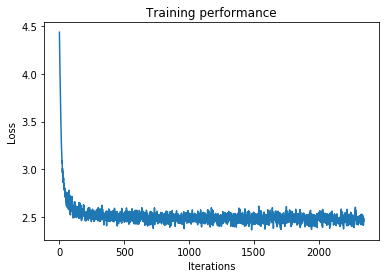

In [9]:
data_set = TextDataset(num_chars=1)
net = OneCharNet().cuda()
train_net(net, data_set, num_epochs=4, batch_size=1024)

## Test the 1-Character Feed-forward Network

By _test_ I really mean _poke it with a stick_. Let's see what kind of text the model will produce from a seed example. You can see that the results suck, but they're _something_.

In [10]:
import random

def generate_text(net, data_set, num_chars, length=100, seed='There will be many issues with', choices=3):
    """
    Use the provided `net` model to generate a sequence of characters, based on the seed.
    """
    text = seed
    for _ in range(length):
        input_text = text[-num_chars:]
        input_idxs = torch.tensor([data_set.char_to_idx[c] for c in input_text]).unsqueeze(dim=0).cuda()
        predictions = net(input_idxs).detach().squeeze().cpu().numpy()
        top_n_idxs = predictions.argsort()[-choices:]
        chosen_idx = random.choice(top_n_idxs)
        chosen_char = data_set.idx_to_char[chosen_idx.item()]
        text += chosen_char
    
    return text

In [11]:
generated_text = generate_text(net, data_set, 1, choices=1)
print(repr(generated_text))

'There will be many issues withe the the the the the the the the the the the the the the the the the the the the the the the the th'


In [12]:
generated_text = generate_text(net, data_set, 1, choices=2)
print(repr(generated_text))

'There will be many issues withalllind thallin alllind an thalllind t and t alit t alllin t thallithallin alllllind an thanderer an'


In [13]:
generated_text = generate_text(net, data_set, 1, choices=3)
print(repr(generated_text))

'There will be many issues withatingeralllinghangesthitise ale t of onge o tinghis alle atisestist o o atit an allis anghise thin o'


## Define a 2-Character Feed-forward Network

Lets add a 2nd character to the inputs. Now our network:

- takes two characters as an input
- transforms each character integer into an embedding
- runs the 1st char's embedding through a hidden layer
- runs the 2nd char's embedding, plus the 1st hidden layer through another hidden layer
- returns a softmax classification over all possible character classes


```

INPUT            EMBED          DENSE 1            DENSE 2           SOFTMAX

1st char idx --> embedding -->  linear + relu -->  linear + relu
                                                      |
                                                      v
2nd char idx --> embedding -->  linear + relu -->  linear + relu --> linear + softmax
                                                                          |
                                                                          v
                                                                     output char idx predictions
```

In [14]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense 1
    (HIDDEN_PARAMS, HIDDEN_PARAMS),  # Dense 2
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class TwoCharNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense_1 = nn.Linear(*LAYERS[1])
        self.dense_2 = nn.Linear(*LAYERS[2])
        self.out = nn.Linear(*LAYERS[3])
        # Functions
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        embed_acts = self.embedding(input_t)
        dense_1_acts = self.relu(self.dense_1(embed_acts))
        char_1 = dense_1_acts[:, 0, :]
        char_2 = dense_1_acts[:, 1, :]

        dense_2_acts = self.relu(self.dense_2(char_1))
        dense_2_acts = self.relu(self.dense_2(dense_2_acts + char_2))
        prediction = self.softmax(self.out(dense_2_acts))
        return prediction

## Train the 2-Character Feed-forward Network

You can see that using 2 characters instead of one slightly improves our final loss.

Creating data loader... done


epoch 1 / 4, loss: 2.0872


epoch 2 / 4, loss: 2.0734


epoch 3 / 4, loss: 2.0508


epoch 4 / 4, loss: 2.0419


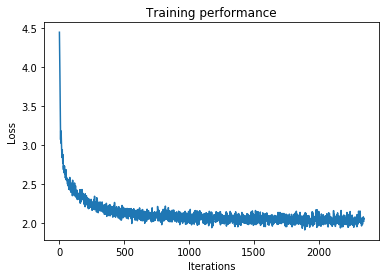

In [15]:
data_set = TextDataset(num_chars=2)
two_char_net = TwoCharNet().cuda()
train_net(two_char_net, data_set, num_epochs=4, batch_size=1024)

## Test the 2-Character Feed-forward Network

It's... slightly better than before.

In [16]:
generated_text = generate_text(two_char_net, data_set, 2, choices=1)
print(generated_text)

There will be many issues withe the the the the the the the the the the the the the the the the the the the the the the the the th


In [17]:
generated_text = generate_text(two_char_net, data_set, 2, choices=2)
print(generated_text)

There will be many issues wither to to the se tooder thas tooderessin thatere ther all an ing an took oner to thate thas ther the 


In [18]:
generated_text = generate_text(two_char_net, data_set, 2, choices=3)
print(generated_text)

There will be many issues witherse tral ancte sent tratimpt truen trestate ing, they of
to
der astailostaidur to
me in thin trat i


## Define an N-Character Feed-forward Network

Lets modify our 2-character network to allow an arbitrary number of characters as inputs. Now our network will now look like this:

```

INPUT            EMBED          DENSE 1            DENSE 2           SOFTMAX

1st char idx --> embedding -->  linear + relu -->  linear + relu
                                                      |
                                                      v
2nd char idx --> embedding -->  linear + relu -->  linear + relu
                                                      |
                                                      v
                                                     ...
                                                      |
                                                      v
nth char idx --> embedding -->  linear + relu -->  linear + relu --> linear + softmax
                                                                          |
                                                                          v
                                                                     output char idx predictions
```

In [19]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense 1
    (HIDDEN_PARAMS, HIDDEN_PARAMS),  # Dense 2
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNet(nn.Module):
    def __init__(self, n):
        super().__init__()    
        # Number of characters as input
        self.n = n
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense_1 = nn.Linear(*LAYERS[1])
        self.dense_2 = nn.Linear(*LAYERS[2])
        self.out = nn.Linear(*LAYERS[3])
        # Functions
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        embed_acts = self.embedding(input_t)
        dense_1_acts = self.relu(self.dense_1(embed_acts))
        shape = dense_1_acts.shape
        assert shape[1] == self.n, f'Incorrect input size in shape {shape}'
        
        dense_2_acts = torch.zeros(shape[0], shape[2]).cuda()
        for i in range(n):
            char_acts = dense_1_acts[:, i, :]
            dense_2_acts = self.relu(self.dense_2(dense_2_acts + char_acts))

        prediction = self.softmax(self.out(dense_2_acts))
        return prediction

## Train the N-Character Feed-forward Network

You can see that using more characters continues to improve our final loss. We're also able to train out networks for longer. I also tweaked the batch size here to be smaller. This will take longer to compute, but will probably result in less redundant computation and thus a better overall loss.

Creating data loader... done


epoch 1 / 8, loss: 1.8019


epoch 2 / 8, loss: 1.6276


epoch 3 / 8, loss: 1.6041


epoch 4 / 8, loss: 1.5621


epoch 5 / 8, loss: 1.5155


epoch 6 / 8, loss: 1.5221


epoch 7 / 8, loss: 1.4838


epoch 8 / 8, loss: 1.4518


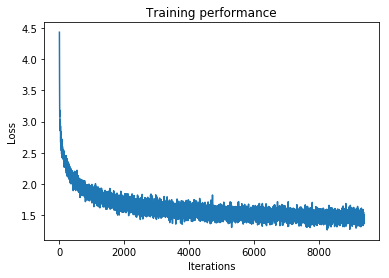

In [39]:
n = 12
data_set = TextDataset(num_chars=n)
n_char_net = NCharNet(n).cuda()
train_net(n_char_net, data_set, num_epochs=8, batch_size=512)

## Test the N-Character Feed-forward Network

This is the best result so far. It's not _great_ but it's much better than the 2-layer network.

In [40]:
generated_text = generate_text(n_char_net, data_set, n, choices=1)
print(generated_text)

There will be many issues with the sense of the such a such a such a such a such a such a such a such a such a such a such a such 


In [44]:
seed = 'Who is to say what the'
generated_text = generate_text(n_char_net, data_set, n, seed=seed, choices=2)
print(generated_text)

Who is to say what the probably an accept one musian and
can anythers and
self-canntally
to
take a sure than
also that
to 


In [48]:
generated_text = generate_text(n_char_net, data_set, n, choices=2)
print(generated_text)

There will be many issues with also, to
things,
altemptrity. It
it is a phimaur an exterminal also to
all all this to a states and


In [43]:
generated_text = generate_text(n_char_net, data_set, n, choices=3)
print(generated_text)

There will be many issues withicided, in to any
thorogises as it
insight tite
all mode alwrioe any altry.
Tortunity,
is to
been se
